# Research Notebook 

## The goal

The goal here is to understand the impact that data gaps have on the L01 pipeline. As seen, the impact of gaps on the telemetry variables result in a widening of the data gaps in the overall Michelson-like variables. I want to try and understand 

* What type of data gap is most impacted
* What generation of TDI is most impactful
* What do the data gap widening depend on? 
* Can I build a distribution of data gaps?

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from lisaconstants import TROPICALYEAR_J2000DAY
from LISA_artefacts import GapMaskGenerator

In [2]:
import numpy as np

def gap_augmentation_expression(lagrange_order, N_nans, delay, delay_number=1.0):
    """
    Compute the gap augmentation from telemetry to eta variables.
    Returns:
        extra_widening: amount of widening from interpolation
        total_nans: N_nans plus extra_widening
    """
    D = np.floor(delay_number * delay)
    B_1 = 1 + 2 * D - 2 * N_nans
    B_2 = 2 * D - 1

    if 1 < lagrange_order <= B_1:
        extra_widening = lagrange_order + N_nans
    elif lagrange_order <= B_2:
        extra_widening = (lagrange_order + 1) / 2 + D
    else:
        extra_widening = lagrange_order

    return extra_widening, N_nans + extra_widening


def _cascade_widening(lagrange_order, initial_nans, delay, delay_numbers):
    """
    Apply multiple stages of gap widening given a sequence of delay_numbers.
    Returns the final widening and total_nans.
    """
    nans = initial_nans
    for d_num in delay_numbers[:-1]:
        _, nans = gap_augmentation_expression(lagrange_order, nans, delay, delay_number=d_num)
    return gap_augmentation_expression(lagrange_order, nans, delay, delay_number=delay_numbers[-1])


def widening_gap_X1(lagrange_order, N_nans, delay):
    """
    Compute gap augmentation from eta to X1 variables.
    """
    return _cascade_widening(lagrange_order, N_nans, delay, [1, 1, 2])


def widening_gap_X2(lagrange_order, N_nans, delay):
    """
    Compute gap augmentation from X1 to X2 variables (fully factorized).
    """
    _, total_nans_X1 = widening_gap_X1(lagrange_order, N_nans, delay)
    return gap_augmentation_expression(lagrange_order, total_nans_X1, delay, delay_number=4.0)


def widening_gap_X1_unfactorized(lagrange_order, N_nans, delay):
    """
    Compute gap augmentation from eta to X1 variables (unfactorized).
    """
    return _cascade_widening(lagrange_order, N_nans, delay, [1, 3])


def widening_gap_X2_unfactorized(lagrange_order, N_nans, delay):
    """
    Compute gap augmentation from eta to X2 variables (unfactorized).
    """
    return _cascade_widening(lagrange_order, N_nans, delay, [1, 7])


def merge_intervals(intervals):
    """Merge overlapping or adjacent intervals."""
    if not intervals:
        return []

    # Sort by start of interval
    intervals.sort(key=lambda x: x[0])
    merged = [intervals[0]]

    for current in intervals[1:]:
        prev = merged[-1]
        if current[0] <= prev[1] + 1:  # Overlapping or adjacent
            merged[-1] = (prev[0], max(prev[1], current[1]))
        else:
            merged.append(current)
    return merged

def nans_blocks_function(object_w_nans): 
    
    nan_indices = np.argwhere(np.isnan(object_w_nans)).flatten()
    if nan_indices.size == 0:
        return np.array([], dtype=int)

    # Identify contiguous NaN segments
    return np.split(nan_indices, np.where(np.diff(nan_indices) > 1)[0] + 1) 

def approx_total_nans_from_nan_blocks_eta(object_w_nans, lagrange_order=45, delay_number=1.0):
    """
    Compute the widening of gaps based on specific NaN blocks in the input vector.
    This function identifies contiguous blocks of NaNs and computes the widening for each block.
    """

    # Identify indices of NaNs
    # nan_indices = np.argwhere(np.isnan(object_w_nans)).flatten()
    # if nan_indices.size == 0:
    #     return 0, 0  # No NaNs to propagate

    # # Identify contiguous NaN segments
    # nan_blocks = np.split(nan_indices, np.where(np.diff(nan_indices) > 1)[0] + 1)

    delay = (8.333333/0.25) # Compute the delay in samples
    nan_blocks = nans_blocks_function(object_w_nans)
    # Initialize total widening and total NaNs
    total_nans = 0

    for block in nan_blocks:
        # Compute the number of NaNs in the current block
        block_size = len(block)

        # Compute widening for the current block using gap_augmentation_expression
        _, total_nans_block = gap_augmentation_expression(
            lagrange_order, block_size, delay, 1
        )

        # Accumulate results
        total_nans += total_nans_block

    return total_nans

def approx_total_nans_from_nan_blocks_X(object_w_nans, lagrange_order=45, generation = 2):
    """
    Compute the widening of gaps based on specific NaN blocks in the input vector.
    This function identifies contiguous blocks of NaNs and computes the widening for each block.
    """

    # Identify indices of NaNs
    # nan_indices = np.argwhere(np.isnan(object_w_nans)).flatten()
    # if nan_indices.size == 0:
    #     return 0, 0  # No NaNs to propagate

    # # Identify contiguous NaN segments
    # nan_blocks = np.split(nan_indices, np.where(np.diff(nan_indices) > 1)[0] + 1)

    delay = (8.333333/0.25) # Compute the delay in samples
    nan_blocks = nans_blocks_function(object_w_nans)
    # Initialize total widening and total NaNs
    total_widening = 0
    total_nans = 0

    for block in nan_blocks:
        # Compute the number of NaNs in the current block
        block_size = len(block)

        # Compute widening for the current block using gap_augmentation_expression
        if generation == 1:
            _, total_nans_block = widening_gap_X1(lagrange_order, block_size, delay)
        elif generation == 2:
            _, total_nans_block = widening_gap_X2(lagrange_order, block_size, delay)

        # Accumulate results
        total_nans += total_nans_block

    return int(total_nans)
def compute_nan_indices_delay(object_w_nans, delay=33, order=45):
    """
    Generalized function to compute eta NaN indices due to multiple telemetry NaN gaps,
    with interval merging to avoid overlaps.
    """

    # nan_indices = np.argwhere(np.isnan(object_w_nans)).flatten()
    # N_original_series = len(object_w_nans)
    # if nan_indices.size == 0:
    #     return np.array([], dtype=int)

    # # Identify contiguous NaN segments
    # nan_blocks = np.split(nan_indices, np.where(np.diff(nan_indices) > 1)[0] + 1)

    N_original_series = len(object_w_nans)
    nan_blocks = nans_blocks_function(object_w_nans)

    # Store all intervals affected
    affected_intervals = []

    p = int((order + 1) / 2)

    for block in nan_blocks:
        n_object_first = block[0]
        n_object_last = block[-1]

        # Direct NaNs
        direct_start = n_object_first
        direct_end = n_object_last

        # Delayed NaNs (inclusive)
        delay_start = n_object_first + delay - p + 1
        delay_end = n_object_last + delay - (1 - p) + 1

        affected_intervals.append((direct_start, direct_end))
        affected_intervals.append((delay_start, delay_end))

    # Merge overlapping/adjacent intervals
    merged_intervals = merge_intervals(affected_intervals)

    # Generate unique indices from merged intervals
    affected_indices = np.concatenate([
        np.arange(start, end + 1) for start, end in merged_intervals
    ])

    affected_indices = affected_indices[(affected_indices >= 0) & (affected_indices < N_original_series)]
    affected_indices = np.unique(affected_indices)

    # # Create eta mask array: 1s and NaNs
    new_mask_like_array = np.ones_like(object_w_nans, dtype=float)
    new_mask_like_array[affected_indices] = np.nan

    return  new_mask_like_array

def mask_eta(mask_telemetry, delay = 33, order = 45, generation = 2):
    delay = 8.33333/0.25
    new_mask_like_array_eta = compute_nan_indices_delay(mask_telemetry, delay = int(np.floor(delay)), order=order)

    return new_mask_like_array_eta
    
def mask_TDI_X(mask_telemetry, order = 45, generation = 2):
    delay = 8.33333/0.25
    new_mask_like_array_eta = compute_nan_indices_delay(mask_telemetry, delay = int(np.floor(delay)), order=order)
    new_mask_like_array_a12 = compute_nan_indices_delay(new_mask_like_array_eta, delay= int(np.floor(delay)), order=order)
    new_mask_like_array_r12 = compute_nan_indices_delay(new_mask_like_array_a12, delay= int(np.floor(2*delay)), order=order)  

    if generation == 1:
        return new_mask_like_array_r12
    else:
        new_mask_like_array_q21 = compute_nan_indices_delay(new_mask_like_array_r12, delay= int(np.floor(4*delay)), order=45) 
        return new_mask_like_array_q21

# Create vague gap function to be used for paper

In [4]:
# Generate the mask with sampling interval 0.25 seconds

# Define the gap function 

# Construct gap class

dt = 10  # seconds
ONE_YEAR = TROPICALYEAR_J2000DAY * 24 * 60 * 60   # seconds
T_obs = 4*ONE_YEAR 
# from gap_mask_gekneration import GapMaskGenerator

sim_t = np.arange(0, T_obs, dt)

gap_definitions_paper = {
    "planned": {
        "Long Duration:": {"rate_per_year": 6, "duration_hr": 40},
        "Medium Duration": {"rate_per_year": 26, "duration_hr": 3.3},
        "Short Duration": {"rate_per_year": 1095, "duration_hr": 0.028}, # 2 second
    },
    "unplanned": {
        "Platform interruptions": {"rate_per_year": 3, "duration_hr": 60},
        "Payload interruptions": {"rate_per_year": 4, "duration_hr": 66},
        "Environmental Interruptions": {"rate_per_year": 30, "duration_hr": 24},
        # "Unknown": {"rate_per_year": 300_000, "duration_hr": 2/(60*60)}, # 2 second
    }
}

# Initialise class with rates, and sampling properties.
generator_w_short_gaps = GapMaskGenerator(
    sim_t,
    dt,
    gap_definitions_paper,
    treat_as_nan=True,
    planseed=11_07_1993,
    unplanseed = 16_12_1997
)

# Generate the mask full of gaps
full_mask_paper_both = generator_w_short_gaps.generate_mask(include_unplanned=True, include_planned=True)
full_mask_paper_planned = generator_w_short_gaps.generate_mask(include_unplanned=False, include_planned=True)
full_mask_paper_unplanned = generator_w_short_gaps.generate_mask(include_unplanned=True, include_planned=False)

extract_summary_both = generator_w_short_gaps.summary(mask = full_mask_paper_both)
extract_summary_planned = generator_w_short_gaps.summary(mask = full_mask_paper_planned)
extract_summary_unplanned = generator_w_short_gaps.summary(mask = full_mask_paper_unplanned)
from pprint import pprint
print("For both planned and unplanned gaps:")
pprint(extract_summary_both['mask_analysis'])
print("")
print("For planned gaps only:")
pprint(extract_summary_planned['mask_analysis'])
print("")
print("For unplanned gaps only:")
pprint(extract_summary_unplanned['mask_analysis'])  


For both planned and unplanned gaps:
{'duty_cycle_percent': np.float64(84.6933),
 'number_of_gap_segments': 3944,
 'total_gap_hours': np.float64(5367.04),
 'total_gap_samples': 1932133}

For planned gaps only:
{'duty_cycle_percent': np.float64(96.1117),
 'number_of_gap_segments': 4339,
 'total_gap_hours': np.float64(1363.38),
 'total_gap_samples': 490815}

For unplanned gaps only:
{'duty_cycle_percent': np.float64(88.1448),
 'number_of_gap_segments': 126,
 'total_gap_hours': np.float64(4156.82),
 'total_gap_samples': 1496454}


In [5]:
import numpy as np
from tqdm import tqdm as tqdm
from pprint import pprint

# Number of realizations
num_realizations = 2_000

# Initialize storage for statistics
statistics = {
    "both": {"duty_cycle_percent": [], "number_of_gap_segments": [], "total_gap_hours": [], "total_gap_samples": []},
    "planned": {"duty_cycle_percent": [], "number_of_gap_segments": [], "total_gap_hours": [], "total_gap_samples": []},
    "unplanned": {"duty_cycle_percent": [], "number_of_gap_segments": [], "total_gap_hours": [], "total_gap_samples": []},
}

# Simulate 10,000 realizations for each combination
for i in tqdm(range(num_realizations)):
    generator_w_short_gaps = GapMaskGenerator(
    sim_t,
    dt,
    gap_definitions_paper,
    treat_as_nan=True,
    planseed=i,
    unplanseed = i+1
    )
    # Generate masks for each combination
    mask_both = generator_w_short_gaps.generate_mask(include_unplanned=True, include_planned=True)
    mask_planned = generator_w_short_gaps.generate_mask(include_unplanned=False, include_planned=True)
    mask_unplanned = generator_w_short_gaps.generate_mask(include_unplanned=True, include_planned=False)

    nans_from_planned_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_both, lagrange_order=45, generation=2)
    nans_from_planned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_planned, lagrange_order=45, generation=2)
    nans_from_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_unplanned, lagrange_order=45, generation=2)
    
    # Extract summaries for each mask
    summary_both = generator_w_short_gaps.summary(mask=mask_both)["mask_analysis"]
    summary_planned = generator_w_short_gaps.summary(mask=mask_planned)["mask_analysis"]
    summary_unplanned = generator_w_short_gaps.summary(mask=mask_unplanned)["mask_analysis"]
    
    # Store statistics for "both"
    statistics["both"]["duty_cycle_percent"].append(summary_both["duty_cycle_percent"])
    statistics["both"]["number_of_gap_segments"].append(summary_both["number_of_gap_segments"])
    statistics["both"]["total_gap_hours"].append(summary_both["total_gap_hours"])
    statistics["both"]["total_gap_samples"].append(summary_both["total_gap_samples"])
    
    # Store statistics for "planned"
    statistics["planned"]["duty_cycle_percent"].append(summary_planned["duty_cycle_percent"])
    statistics["planned"]["number_of_gap_segments"].append(summary_planned["number_of_gap_segments"])
    statistics["planned"]["total_gap_hours"].append(summary_planned["total_gap_hours"])
    statistics["planned"]["total_gap_samples"].append(summary_planned["total_gap_samples"])
    
    # Store statistics for "unplanned"
    statistics["unplanned"]["duty_cycle_percent"].append(summary_unplanned["duty_cycle_percent"])
    statistics["unplanned"]["number_of_gap_segments"].append(summary_unplanned["number_of_gap_segments"])
    statistics["unplanned"]["total_gap_hours"].append(summary_unplanned["total_gap_hours"])
    statistics["unplanned"]["total_gap_samples"].append(summary_unplanned["total_gap_samples"])

# Convert statistics to numpy arrays for easier analysis
for key in statistics.keys():
    for stat_key in statistics[key].keys():
        statistics[key][stat_key] = np.array(statistics[key][stat_key])



  0%|          | 10/2000 [00:11<37:25,  1.13s/it]


KeyboardInterrupt: 

In [67]:
# Print summary statistics for each combination
print("Summary Statistics for Both Planned and Unplanned Gaps:")
pprint({
    "Mean Duty Cycle Percent": np.median(statistics["both"]["duty_cycle_percent"]),
    "Mean Number of Gap Segments": np.median(statistics["both"]["number_of_gap_segments"]),
    "Mean Total Gap Hours": np.median(statistics["both"]["total_gap_hours"]),
    "Mean Total Gap Samples": np.median(statistics["both"]["total_gap_samples"]),
})

print("\nSummary Statistics for Planned Gaps Only:")
pprint({
    "Mean Duty Cycle Percent": np.median(statistics["planned"]["duty_cycle_percent"]),
    "Mean Number of Gap Segments": np.median(statistics["planned"]["number_of_gap_segments"]),
    "Mean Total Gap Hours": np.median(statistics["planned"]["total_gap_hours"]),
    "Mean Total Gap Samples": np.median(statistics["planned"]["total_gap_samples"]),
})

print("\nSummary Statistics for Unplanned Gaps Only:")
pprint({
    "Mean Duty Cycle Percent": np.median(statistics["unplanned"]["duty_cycle_percent"]),
    "Mean Number of Gap Segments": np.median(statistics["unplanned"]["number_of_gap_segments"]),
    "Mean Total Gap Hours": np.median(statistics["unplanned"]["total_gap_hours"]),
    "Mean Total Gap Samples": np.median(statistics["unplanned"]["total_gap_samples"]),
})

Summary Statistics for Both Planned and Unplanned Gaps:
{'Mean Duty Cycle Percent': np.float64(84.69915),
 'Mean Number of Gap Segments': np.float64(3945.0),
 'Mean Total Gap Hours': np.float64(5364.98),
 'Mean Total Gap Samples': np.float64(1931392.5)}

Summary Statistics for Planned Gaps Only:
{'Mean Duty Cycle Percent': np.float64(96.1195),
 'Mean Number of Gap Segments': np.float64(4342.0),
 'Mean Total Gap Hours': np.float64(1360.6350000000002),
 'Mean Total Gap Samples': np.float64(489828.5)}

Summary Statistics for Unplanned Gaps Only:
{'Mean Duty Cycle Percent': np.float64(88.08760000000001),
 'Mean Number of Gap Segments': np.float64(125.0),
 'Mean Total Gap Hours': np.float64(4176.87),
 'Mean Total Gap Samples': np.float64(1503673.5)}


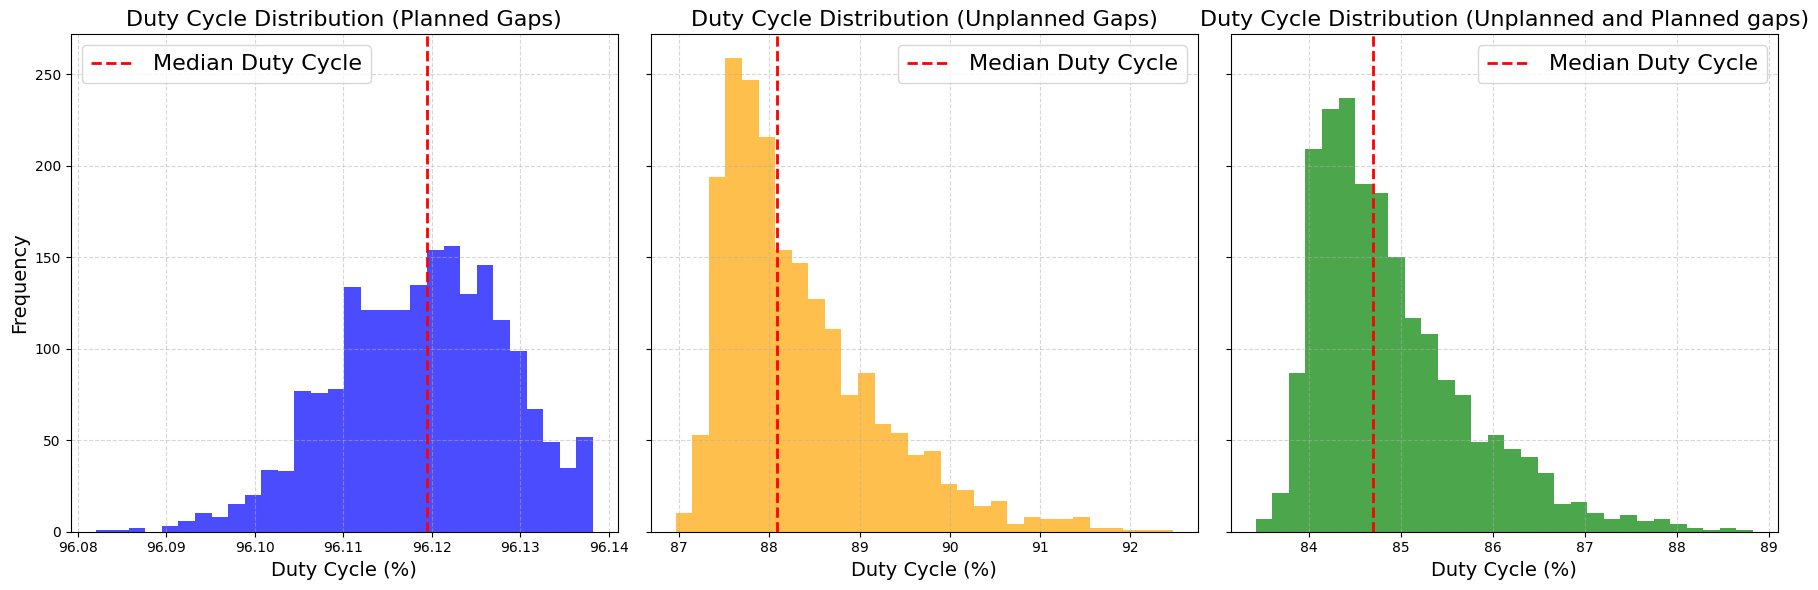

In [86]:
import matplotlib.pyplot as plt

def plot_statistics(ax, data, color):
    mean = np.median(data)
    quantiles = np.percentile(data, [25, 50, 75])
    
    # Plot mean
    ax.axvline(mean, color=color, linestyle="--", linewidth=2, label=f"Mean: {mean:.2f}", c = 'black')
    
    # Plot quantiles
    ax.axvline(quantiles[0], color=color, linestyle=":", linewidth=2, label=f"25th Percentile: {quantiles[0]:.2f}")
    ax.axvline(quantiles[1], color=color, linestyle="-.", linewidth=2, label=f"50th Percentile (Median): {quantiles[1]:.2f}")
    ax.axvline(quantiles[2], color=color, linestyle=":", linewidth=2, label=f"75th Percentile: {quantiles[2]:.2f}")
    
    return mean, quantiles

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)


# Plot for planned gaps
axes[0].hist(statistics["planned"]["duty_cycle_percent"], bins=30, color="blue", alpha=0.7)
axes[0].set_title("Duty Cycle Distribution (Planned Gaps)", fontsize=16)
axes[0].set_xlabel("Duty Cycle (%)", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].axvline(x = np.median(statistics["planned"]["duty_cycle_percent"]),c = 'red', linestyle='--', linewidth=2, label='Median Duty Cycle')
    
# Plot for unplanned gaps
axes[1].hist(statistics["unplanned"]["duty_cycle_percent"], bins=30, color="orange", alpha=0.7)
axes[1].set_title("Duty Cycle Distribution (Unplanned Gaps)", fontsize=16)
axes[1].set_xlabel("Duty Cycle (%)", fontsize=14)
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].axvline(x = np.median(statistics["unplanned"]["duty_cycle_percent"]),c = 'red', linestyle='--', linewidth=2, label='Median Duty Cycle')

# Plot for both planned and unplanned gaps
axes[2].hist(statistics["both"]["duty_cycle_percent"], bins=30, color="green", alpha=0.7)
axes[2].set_title("Duty Cycle Distribution (Unplanned and Planned gaps)", fontsize=16)
axes[2].set_xlabel("Duty Cycle (%)", fontsize=14)
axes[2].grid(True, linestyle="--", alpha=0.5)
axes[2].axvline(x = np.median(statistics["both"]["duty_cycle_percent"]),c = 'red', linestyle='--', linewidth=2, label='Median Duty Cycle')

for j in range(3):
    axes[j].legend(fontsize=16)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("Duty_Cycle_Distribution_paper.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
len(mask_both)/small_dt /60/60/24/365

1.6010617706747843

In [31]:
import numpy as np
from tqdm import tqdm as tqdm
from pprint import pprint

small_dt = 0.25 # seconds
ONE_YEAR = TROPICALYEAR_J2000DAY * 24 * 60 * 60   # seconds
T_obs = 4*ONE_YEAR 
# from gap_mask_gekneration import GapMaskGenerator

sim_t = np.arange(0, T_obs, small_dt)

# Number of realizations
num_realizations = 20

# Initialize storage for statistics
statistics_small_dt = {
    "both": {
        "duty_cycle_percent": [],
        "number_of_gap_segments": [],
        "total_gap_hours": [],
        "total_gap_samples": [],
        "duty_cycle_after_widening_TDIX2": []  # New field for duty cycle after widening
    },
    "planned": {
        "duty_cycle_percent": [],
        "number_of_gap_segments": [],
        "total_gap_hours": [],
        "total_gap_samples": [],
        "duty_cycle_after_widening_TDIX2": []  # New field for duty cycle after widening
    },
    "unplanned": {
        "duty_cycle_percent": [],
        "number_of_gap_segments": [],
        "total_gap_hours": [],
        "total_gap_samples": [],
        "duty_cycle_after_widening_TDIX2": []  # New field for duty cycle after widening
    },
}

# Simulate 10,000 realizations for each combination
total_samples = len(sim_t)
for i in tqdm(range(num_realizations)):
# Initialise class with rates, and sampling properties.
    generator_w_short_gaps_small_dt = GapMaskGenerator(
        sim_t,
        0.25,
        gap_definitions_paper,
        treat_as_nan=True,
        planseed=i,
        unplanseed = i+1
    )

    # Generate masks for each combination
    mask_both = generator_w_short_gaps_small_dt.generate_mask(include_unplanned=True, include_planned=True)
    mask_planned = generator_w_short_gaps_small_dt.generate_mask(include_unplanned=False, include_planned=True)
    mask_unplanned = generator_w_short_gaps_small_dt.generate_mask(include_unplanned=True, include_planned=False)

    nans_from_planned_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_both, lagrange_order=45, generation=2)
    nans_from_planned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_planned, lagrange_order=45, generation=2)
    nans_from_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_unplanned, lagrange_order=45, generation=2)

    # Compute duty cycle after widening for TDI X2
    duty_cycle_after_widening_both = 100 * (1 - nans_from_planned_unplanned_TDIX2 / total_samples)
    duty_cycle_after_widening_planned = 100 * (1 - nans_from_planned_TDIX2 / total_samples)
    duty_cycle_after_widening_unplanned = 100 * (1 - nans_from_unplanned_TDIX2 / total_samples)
    
    # Extract summaries for each mask
    summary_both = generator_w_short_gaps_small_dt.summary(mask=mask_both)["mask_analysis"]
    summary_planned = generator_w_short_gaps_small_dt.summary(mask=mask_planned)["mask_analysis"]
    summary_unplanned = generator_w_short_gaps_small_dt.summary(mask=mask_unplanned)["mask_analysis"]
    
    # Store statistics for "both"
    statistics_small_dt["both"]["duty_cycle_percent"].append(summary_both["duty_cycle_percent"])
    statistics_small_dt["both"]["number_of_gap_segments"].append(summary_both["number_of_gap_segments"])
    statistics_small_dt["both"]["total_gap_hours"].append(summary_both["total_gap_hours"])
    statistics_small_dt["both"]["total_gap_samples"].append(summary_both["total_gap_samples"])
    statistics_small_dt["both"]["duty_cycle_after_widening_TDIX2"].append(duty_cycle_after_widening_both)
    
    # Store st_small_dtatistics for "planned"
    statistics_small_dt["planned"]["duty_cycle_percent"].append(summary_planned["duty_cycle_percent"])
    statistics_small_dt["planned"]["number_of_gap_segments"].append(summary_planned["number_of_gap_segments"])
    statistics_small_dt["planned"]["total_gap_hours"].append(summary_planned["total_gap_hours"])
    statistics_small_dt["planned"]["total_gap_samples"].append(summary_planned["total_gap_samples"])
    statistics_small_dt["planned"]["duty_cycle_after_widening_TDIX2"].append(duty_cycle_after_widening_planned)
    
    # Store st_small_dtatistics for "unplanned"
    statistics_small_dt["unplanned"]["duty_cycle_percent"].append(summary_unplanned["duty_cycle_percent"])
    statistics_small_dt["unplanned"]["number_of_gap_segments"].append(summary_unplanned["number_of_gap_segments"])
    statistics_small_dt["unplanned"]["total_gap_hours"].append(summary_unplanned["total_gap_hours"])
    statistics_small_dt["unplanned"]["total_gap_samples"].append(summary_unplanned["total_gap_samples"])
    statistics_small_dt["unplanned"]["duty_cycle_after_widening_TDIX2"].append(duty_cycle_after_widening_unplanned)

# Convert statistics to numpy arrays for easier analysis
for key in statistics_small_dt.keys():
    for stat_key in statistics_small_dt[key].keys():
        statistics_small_dt[key][stat_key] = np.array(statistics_small_dt[key][stat_key])

# Print a summary of the new duty cycle after widening
print("Summary of Duty Cycle After Widening (TDI X2):")
for key in statistics_small_dt.keys():
    print(f"{key.capitalize()} Gaps:")
    print(f" median Duty cycle before widening: {np.median(statistics_small_dt[key]['duty_cycle_percent']):.2f}%")
    print(f"  Median Duty Cycle After Widening: {np.median(statistics_small_dt[key]['duty_cycle_after_widening_TDIX2']):.2f}%")
    print()

100%|██████████| 20/20 [22:15<00:00, 66.77s/it]

Summary of Duty Cycle After Widening (TDI X2):
Both Gaps:
 median Duty cycle before widening: 84.52%
  Median Duty Cycle After Widening: 84.24%

Planned Gaps:
 median Duty cycle before widening: 96.12%
  Median Duty Cycle After Widening: 95.81%

Unplanned Gaps:
 median Duty cycle before widening: 87.88%
  Median Duty Cycle After Widening: 87.87%



In [32]:
# Now to understand precisely how much data is lost due to the widening of gaps, we can compute the difference between the duty cycle before and after widening.
N_nans_from_telemetry_both = np.sum(np.isnan(mask_both))
N_nans_from_telemetry_planned = np.sum(np.isnan(mask_planned))
N_nans_from_telemetry_unplanned = np.sum(np.isnan(mask_unplanned))

In [33]:
    
print("Planned + unplanned gaps = Amount of data lost is ", (nans_from_planned_unplanned_TDIX2 - N_nans_from_telemetry_both)*0.25/60/60/24)
print("Planned gaps = Amount of data lost is ", (nans_from_planned_TDIX2 - N_nans_from_telemetry_planned)*0.25/60/60/24)
print("unplanned gaps = Amount of data lost is ", (nans_from_unplanned_TDIX2 - N_nans_from_telemetry_unplanned)*0.25/60/60/24)

Planned + unplanned gaps = Amount of data lost is  4.07203125
Planned gaps = Amount of data lost is  4.485225694444445
unplanned gaps = Amount of data lost is  0.13428819444444445


In [ ]:
from joblib import Parallel, delayed
import numpy as np

num_realizations = 20

def process_realization(i):
    # Initialize the generator
    generator = GapMaskGenerator(
        sim_t,
        small_dt,
        gap_definitions_paper,
        treat_as_nan=True,
        planseed=i,
        unplanseed=i+1
    )

     
    # Generate masks for each combination
    mask_both = generator.generate_mask(include_unplanned=True, include_planned=True)
    mask_planned = generator.generate_mask(include_unplanned=False, include_planned=True)
    mask_unplanned = generator.generate_mask(include_unplanned=True, include_planned=False)
    
    # Compute total samples (length of the mask)
    total_samples = len(mask_both)
    
    # Approximate NaNs after widening for TDI X2
    nans_from_planned_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_both, lagrange_order=45, generation=2)
    nans_from_planned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_planned, lagrange_order=45, generation=2)
    nans_from_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_unplanned, lagrange_order=45, generation=2)
    
    # Compute duty cycle after widening for TDI X2
    duty_cycle_after_widening_both = 100 * (1 - nans_from_planned_unplanned_TDIX2 / total_samples)
    duty_cycle_after_widening_planned = 100 * (1 - nans_from_planned_TDIX2 / total_samples)
    duty_cycle_after_widening_unplanned = 100 * (1 - nans_from_unplanned_TDIX2 / total_samples)
    
    # Extract summaries for each mask
    summary_both = generator.summary(mask=mask_both)["mask_analysis"]
    summary_planned = generator.summary(mask=mask_planned)["mask_analysis"]
    summary_unplanned = generator.summary(mask=mask_unplanned)["mask_analysis"]
     
    # Return results for this realization
    return {
        "both": {
            "duty_cycle_percent": summary_both["duty_cycle_percent"],
            "duty_cycle_after_widening_TDIX2": duty_cycle_after_widening_both,
        },
        "planned": {
            "duty_cycle_percent": summary_planned["duty_cycle_percent"],
            "duty_cycle_after_widening_TDIX2": duty_cycle_after_widening_planned,
        },
        "unplanned": {
            "duty_cycle_percent": summary_unplanned["duty_cycle_percent"],
            "duty_cycle_after_widening_TDIX2": duty_cycle_after_widening_unplanned,
        },
    }

# Run in parallel
results = Parallel(n_jobs=-1)(delayed(process_realization)(i) for i in range(num_realizations))

# Initialize storage for statistics
statistics_small_dt = {
    "both": {"duty_cycle_percent": [], "duty_cycle_after_widening_TDIX2": []},
    "planned": {"duty_cycle_percent": [], "duty_cycle_after_widening_TDIX2": []},
    "unplanned": {"duty_cycle_percent": [], "duty_cycle_after_widening_TDIX2": []},
}

# Aggregate results
for result in results:
    for key in statistics_small_dt.keys():
        statistics_small_dt[key]["duty_cycle_percent"].append(result[key]["duty_cycle_percent"])
        statistics_small_dt[key]["duty_cycle_after_widening_TDIX2"].append(result[key]["duty_cycle_after_widening_TDIX2"])

# Convert lists to numpy arrays for easier analysis
for key in statistics_small_dt.keys():
    for stat_key in statistics_small_dt[key].keys():
        statistics_small_dt[key][stat_key] = np.array(statistics_small_dt[key][stat_key])

# Print summary statistics
print("Summary of Duty Cycle After Widening (TDI X2):")
for key in statistics_small_dt.keys():
    print(f"{key.capitalize()} Gaps:")
    print(f" median Duty cycle before widening: {np.median(statistics_small_dt[key]['duty_cycle_percent']):.6f}%")
    print(f"  Median Duty Cycle After Widening: {np.median(statistics_small_dt[key]['duty_cycle_after_widening_TDIX2']):.6f}%")
    print()

Summary of Duty Cycle After Widening (TDI X2):
Both Gaps:
 median Duty cycle before widening: 91.090500%
  Median Duty Cycle After Widening: 90.796411%

Planned Gaps:
 median Duty cycle before widening: 98.899100%
  Median Duty Cycle After Widening: 98.585144%

Unplanned Gaps:
 median Duty cycle before widening: 91.786300%
  Median Duty Cycle After Widening: 91.777788%



In [23]:
from joblib import Parallel, delayed
import numpy as np

num_realizations = 2000

def process_realization(i):
    # Initialize the generator
    generator = GapMaskGenerator(
        sim_t,
        small_dt,
        gap_definitions_paper,
        treat_as_nan=True,
        planseed=i,
        unplanseed=i+1
    )

     
    # Generate masks for each combination
    mask_both = generator.generate_mask(include_unplanned=True, include_planned=True)
    mask_planned = generator.generate_mask(include_unplanned=False, include_planned=True)
    mask_unplanned = generator.generate_mask(include_unplanned=True, include_planned=False)
    
    # Compute total samples (length of the mask)
    total_samples = len(mask_both)
    
    # Approximate NaNs after widening for TDI X2
    nans_from_planned_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_both, lagrange_order=45, generation=2)
    nans_from_planned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_planned, lagrange_order=45, generation=2)
    nans_from_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_unplanned, lagrange_order=45, generation=2)
    
    # Compute duty cycle after widening for TDI X2
    duty_cycle_after_widening_both = 100 * (1 - nans_from_planned_unplanned_TDIX2 / total_samples)
    duty_cycle_after_widening_planned = 100 * (1 - nans_from_planned_TDIX2 / total_samples)
    duty_cycle_after_widening_unplanned = 100 * (1 - nans_from_unplanned_TDIX2 / total_samples)
    
    # Extract summaries for each mask
    summary_both = generator.summary(mask=mask_both)["mask_analysis"]
    summary_planned = generator.summary(mask=mask_planned)["mask_analysis"]
    summary_unplanned = generator.summary(mask=mask_unplanned)["mask_analysis"]
     
    # Return results for this realization
    return {
        "both": {
            "duty_cycle_percent": summary_both["duty_cycle_percent"],
            "duty_cycle_after_widening_TDIX2": duty_cycle_after_widening_both,
        },
        "planned": {
            "duty_cycle_percent": summary_planned["duty_cycle_percent"],
            "duty_cycle_after_widening_TDIX2": duty_cycle_after_widening_planned,
        },
        "unplanned": {
            "duty_cycle_percent": summary_unplanned["duty_cycle_percent"],
            "duty_cycle_after_widening_TDIX2": duty_cycle_after_widening_unplanned,
        },
    }

# Run in parallel
results = Parallel(n_jobs=-1)(delayed(process_realization)(i) for i in range(num_realizations))

# Initialize storage for statistics
statistics_small_dt = {
    "both": {"duty_cycle_percent": [], "duty_cycle_after_widening_TDIX2": []},
    "planned": {"duty_cycle_percent": [], "duty_cycle_after_widening_TDIX2": []},
    "unplanned": {"duty_cycle_percent": [], "duty_cycle_after_widening_TDIX2": []},
}

# Aggregate results
for result in results:
    for key in statistics_small_dt.keys():
        statistics_small_dt[key]["duty_cycle_percent"].append(result[key]["duty_cycle_percent"])
        statistics_small_dt[key]["duty_cycle_after_widening_TDIX2"].append(result[key]["duty_cycle_after_widening_TDIX2"])

# Convert lists to numpy arrays for easier analysis
for key in statistics_small_dt.keys():
    for stat_key in statistics_small_dt[key].keys():
        statistics_small_dt[key][stat_key] = np.array(statistics_small_dt[key][stat_key])

# Print summary statistics
print("Summary of Duty Cycle After Widening (TDI X2):")
for key in statistics_small_dt.keys():
    print(f"{key.capitalize()} Gaps:")
    print(f" median Duty cycle before widening: {np.median(statistics_small_dt[key]['duty_cycle_percent']):.6f}%")
    print(f"  Median Duty Cycle After Widening: {np.median(statistics_small_dt[key]['duty_cycle_after_widening_TDIX2']):.6f}%")
    print()

Summary of Duty Cycle After Widening (TDI X2):
Both Gaps:
 median Duty cycle before widening: 91.090500%
  Median Duty Cycle After Widening: 90.796411%

Planned Gaps:
 median Duty cycle before widening: 98.899100%
  Median Duty Cycle After Widening: 98.585144%

Unplanned Gaps:
 median Duty cycle before widening: 91.786300%
  Median Duty Cycle After Widening: 91.777788%

